In [1]:
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import glob
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn, optim
import torch.nn.functional as F
import torch
import torchvision

In [2]:
# create data_loader for images
class ImageDataset(Dataset):
    def __init__(self, path, extension='jpg', transforms=None):
        self.transforms = transforms
        self.path = path
        self.image_path_list = glob.glob(f"{path}/*.{extension}")
        
    def __getitem__(self, index):
        data = Image.open(self.image_path_list[index])
        data = data.convert('RGB')
        data = self.transforms(data)  
        
        return data

    def __len__(self):
        return len(self.image_path_list)

In [3]:
batch_size = 4

image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor()
])

image_transforms_hd = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor()
])


dataset = ImageDataset('./photos/train', transforms=image_transforms, extension='jpg')
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset_test = ImageDataset('./photos/test', transforms=image_transforms_hd, extension='jpg')
loader_test = DataLoader(dataset_test, batch_size=1, shuffle=True)

torch.Size([4, 3, 256, 256]) tensor(1.)


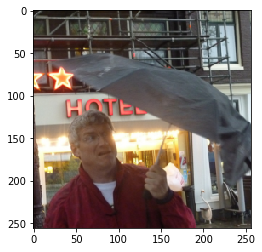

In [4]:
images = next(iter(loader))

print(images.shape, images.max())

plt.imshow(images[0].permute(1, 2, 0))
plt.show()

torch.Size([3, 391, 470]) tensor(0.) tensor(1.)


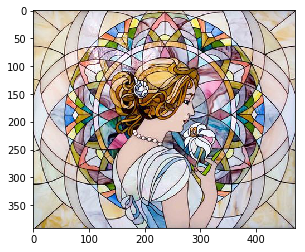

In [5]:
# load style image
style_image = Image.open('styles/mosaic.jpg')
style_image = transforms.ToTensor()(style_image)

print(style_image.shape, style_image.min(), style_image.max())

plt.imshow(style_image.permute(1, 2, 0))
plt.show()

In [6]:
# create feature extractor
vgg = models.vgg16(pretrained=True)
for param in vgg.parameters():
    param.requires_grad = False
print(vgg)
vgg.cuda()

def extract_features(x):
    features = {}
    feature_list = {
        '3': 'relu1_2',
        '8': 'relu2_2',
        '15': 'relu3_3',
        '22': 'relu4_3'
    }
    
    # normalize input to VGG
    mean = x.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = x.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    x = (x - mean) / std
    
    for name, layer in vgg.features._modules.items():
        x = layer(x)
        if name in feature_list.keys():
            features[feature_list[name]] = x

    return features

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [7]:
style_features = extract_features(style_image.unsqueeze(0).cuda())

print(style_features['relu1_2'].shape)
print(style_features['relu2_2'].shape)
print(style_features['relu3_3'].shape)
print(style_features['relu4_3'].shape)

torch.Size([1, 64, 391, 470])
torch.Size([1, 128, 195, 235])
torch.Size([1, 256, 97, 117])
torch.Size([1, 512, 48, 58])


In [24]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        
        self.resblock = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(channels, affine=True),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(channels, affine=True),
        )
        
    def forward(self, x):
        out = self.resblock(x)
        return out + x
        
class Upsample2D(nn.Module):
    def __init__(self, scale_factor, mode):
        super(Upsample2D, self).__init__()
        self.interp = nn.functional.interpolate
        self.scale_factor = scale_factor
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor, mode=self.mode)
        return x

class MicroResNet(nn.Module):
    def __init__(self):
        super(MicroResNet, self).__init__()
        
        self.downsampler = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=9, padding=4),
            nn.InstanceNorm2d(32, affine=True),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
            nn.InstanceNorm2d(128, affine=True),
            nn.ReLU(),
        )
        
        self.residual = ResBlock(128)
        
        self.upsampler = nn.Sequential(
            Upsample2D(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(),
            Upsample2D(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.InstanceNorm2d(32, affine=True),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=9, padding=4),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.downsampler(x)
        for i in range(4):
            out = self.residual(out)
        return self.upsampler(out)

In [25]:
model = MicroResNet()
model

MicroResNet(
  (downsampler): Sequential(
    (0): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (8): ReLU()
  )
  (residual): ResBlock(
    (resblock): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [10]:
sample_imgs = next(iter(loader))

torch.Size([4, 3, 256, 256])


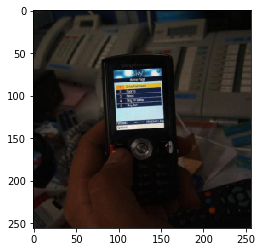

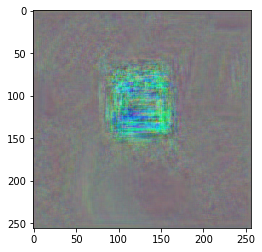

In [11]:
sample_img_idx = 0
model.cuda()
with torch.no_grad():
    model.eval()
    out = model(sample_imgs.cuda()).cpu()
    
    print(out.shape)
    torchvision.utils.save_image(out[sample_img_idx], f'training/0.jpg')

    plt.imshow(sample_imgs[sample_img_idx].permute(1, 2, 0))
    plt.show()
    
    plt.imshow(out[sample_img_idx].permute(1, 2, 0))
    plt.show()

In [12]:
# define perceptual loss methods

def batch_gram_matrix(features):
    shape = features.shape
    flattened = features.view(shape[0], shape[1], shape[2]*shape[3])
    gram_matrix = torch.bmm(flattened, flattened.transpose(2, 1)) / (shape[1] * shape[2] * shape[3])
    
    return gram_matrix

def perceptual_loss(out, style_target, content_target):
    mse = torch.nn.MSELoss()
    
    style_loss = mse(batch_gram_matrix(out['relu1_2']), batch_gram_matrix(style_target['relu1_2']))
    style_loss += mse(batch_gram_matrix(out['relu2_2']), batch_gram_matrix(style_target['relu2_2']))
    style_loss += mse(batch_gram_matrix(out['relu3_3']), batch_gram_matrix(style_target['relu3_3']))
    style_loss += mse(batch_gram_matrix(out['relu4_3']), batch_gram_matrix(style_target['relu4_3']))
    content_loss = mse(out['relu3_3'], content_target['relu3_3'])
    
    return content_loss, style_loss

In [13]:
def batch_style_features(batch_size):
    style_batch = {}
    style_batch['relu1_2'] = style_features['relu1_2'].expand(batch_size, -1, -1, -1)
    style_batch['relu2_2'] = style_features['relu2_2'].expand(batch_size, -1, -1, -1)
    style_batch['relu3_3'] = style_features['relu3_3'].expand(batch_size, -1, -1, -1)
    style_batch['relu4_3'] = style_features['relu4_3'].expand(batch_size, -1, -1, -1)
    
    return style_batch

In [26]:
epochs = 2

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

model.cuda()
for e in range(1, epochs+1):
    model.train()
    train_total_loss = 0
    train_content_loss = 0
    train_style_loss = 0
    batch = 0
    for images in loader:
        batch += 1
        images = images.cuda()
        optimizer.zero_grad()
        
        # replicate style_features to match batch_size
        batch_size = images.size(0)
        style_batch_features = batch_style_features(batch_size)
        content_batch_features = extract_features(images)
                
        pred = model(images)
        pred_features = extract_features(pred)
        
        content_loss, style_loss = perceptual_loss(pred_features, style_batch_features, content_batch_features)
        content_loss *= 1e5
        style_loss *= 1e10
        loss = content_loss + style_loss
        
        train_total_loss += loss.item()
        train_content_loss += content_loss.item()
        train_style_loss += style_loss.item()
        
        loss.backward()
        optimizer.step()
        
        print(f"EPOCH {e} ({batch}/{len(loader)}) - content_loss {train_content_loss/batch:.4f} - style_loss {train_style_loss/batch:.4f} - loss {train_total_loss/batch:.4f}", end='\r')
        
        # if batch % 2000 == 0:
        #     with torch.no_grad():
        #         model.eval()
        #         out = model(sample_imgs.cuda()).cpu()
        #         torchvision.utils.save_image(out[sample_img_idx], f'training/{e}-{batch}.jpg')
    
    scheduler.step(train_total_loss)
    print(f"EPOCH {e} - content_loss {train_content_loss/len(loader):.4f} - style_loss {train_style_loss/len(loader):.4f} - loss {train_total_loss/len(loader):.4f}")
    
    

EPOCH 1 - content_loss 1876357.2051 - style_loss 898944.7286 - loss 2775301.93452775301.93453
EPOCH 2 - content_loss 1549005.7595 - style_loss 628384.0284 - loss 2177389.78892177389.7889


In [27]:
model.cpu()
torch.save(model.state_dict(), 'model_micro.pt')

In [28]:
checkpoint = torch.load('model_micro.pt')
model.load_state_dict(checkpoint)

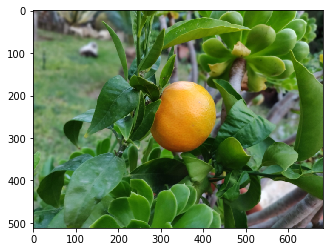

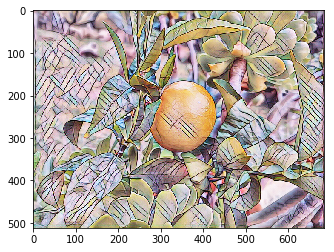

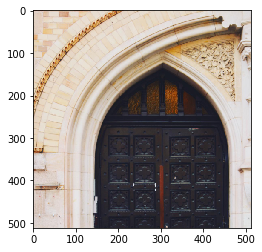

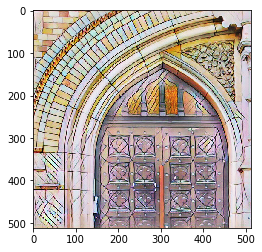

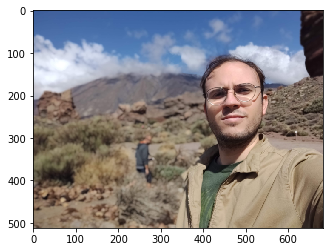

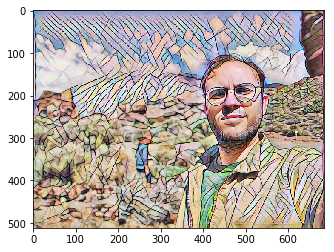

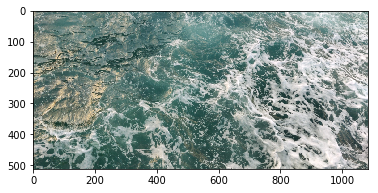

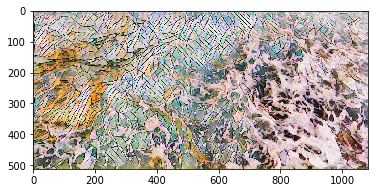

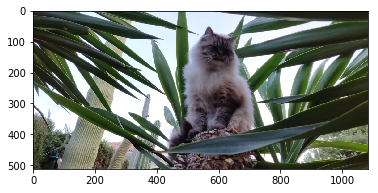

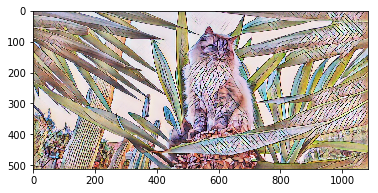

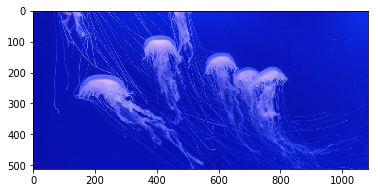

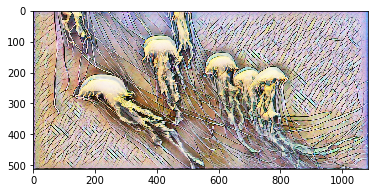

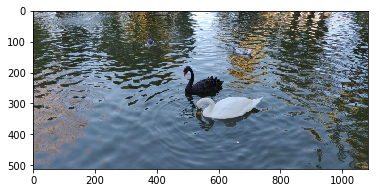

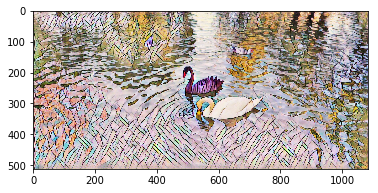

In [29]:
with torch.no_grad():
    model.eval()
    model.cuda()
    count = 0
    
    for image in loader_test:
        count += 1
        out = model(image.cuda()).cpu()
        plt.imshow(image[0].permute(1, 2, 0))
        plt.show()
        
        torchvision.utils.save_image(out[0], f'final/{count}.jpg')

        plt.imshow(out[0].permute(1, 2, 0))
        plt.show()